# Calculate the background per plate

In [26]:
import os
import re
import sys
import glob
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

sys.path.append("../scripts")
from img_utils import letter_dict, channel_dict
letter_dict_rev = {v: k for k, v in letter_dict.items()}
channel_dict_rev = {v: k for k, v in channel_dict.items()}

# letter_dict_rev
# channel_dict_rev

In [27]:
%%bash

# python ../scripts/1_calc_plate_bg.py --batch_list "2024_01_23_Batch_7,2024_02_06_Batch_8,2025_01_27_Batch_13,2025_01_28_Batch_14,2025_03_17_Batch_15,2025_03_17_Batch_16"

## 1. Read in the results

In [10]:
batch = "2025_03_17_Batch_16"

plate_sum = pl.read_parquet(f"../outputs/1.plate_bg_summary/{batch}/plate_sum_stats.parquet")
plate_well_sum = pl.read_parquet(f"../outputs/1.plate_bg_summary/{batch}/plate_well_sum_stats.parquet")
plate_site_sum = pl.read_parquet(f"../outputs/1.plate_bg_summary/{batch}/plate_site_channel.parquet")

# plate_well_sum.filter(~(pl.col("channel").str.contains("Brightfield"))).sort(by=["plate","well"])
plate_well_sum = plate_well_sum.filter(~(pl.col("channel").str.contains("Brightfield"))).sort(by=["plate","well"]).join(plate_sum, on=["plate","channel"], how="left", suffix="_plate")
plate_site_sum = plate_site_sum.filter(~(pl.col("channel").str.contains("Brightfield"))).sort(by=["plate","well"]).join(plate_sum, on=["plate","channel"], how="left", suffix="_plate")

# plate_bg.join(
#     plate_bg.group_by("plate","channel").agg(
#         pl.col("perc_50").median().alias("plate_channel_median")
#     ).with_columns(
#         (pl.col("plate_channel_median")-pl.col("plate_channel_median").median())
#         .abs().median()
#         .alias("plate_channel_mad")
#     ),
#     on=["plate","channel"]
# ).filter((pl.col("channel")=="GFP")&(pl.col("perc_95")<(pl.col("plate_channel_median")+pl.col("plate_channel_mad")))).sort(pl.col("well")).unique(subset="well", keep="first")

In [11]:
plate_site_sum

plate,img_path,site,channel,well,perc_25,perc_50,perc_75,perc_80,perc_90,perc_95,perc_99,median,mean,std
str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64
"""2025-03-17_B16A1A2_P1T1""","""../inputs/images//2025_03_17_B…","""02""","""GFP""","""A01""",162.0,244.0,374.0,419.0,571.0,715.0,1102.0,156,469.882565,2663.648157
"""2025-03-17_B16A1A2_P1T1""","""../inputs/images//2025_03_17_B…","""05""","""DAPI""","""A01""",161.0,182.0,200.0,204.0,221.0,340.0,480.0,182,193.376867,83.841649
"""2025-03-17_B16A1A2_P1T1""","""../inputs/images//2025_03_17_B…","""07""","""DAPI""","""A01""",163.0,183.0,200.0,204.0,216.0,272.0,449.0,182,193.376867,83.841649
"""2025-03-17_B16A1A2_P1T1""","""../inputs/images//2025_03_17_B…","""01""","""AGP""","""A01""",192.0,1244.0,1718.0,1840.0,2191.0,2521.0,3365.0,179,518.982116,613.368581
"""2025-03-17_B16A1A2_P1T1""","""../inputs/images//2025_03_17_B…","""08""","""AGP""","""A01""",163.0,189.0,1337.0,1502.0,1876.0,2166.0,2812.0,179,518.982116,613.368581
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2025-03-18_B16A1A2_P1T4""","""../inputs/images//2025_03_17_B…","""09""","""AGP""","""P24""",137.0,154.0,167.0,170.0,178.0,183.0,196.0,173,409.051663,452.185291
"""2025-03-18_B16A1A2_P1T4""","""../inputs/images//2025_03_17_B…","""01""","""GFP""","""P24""",128.0,143.0,155.0,158.0,165.0,170.0,179.0,0,NaN,NaN
"""2025-03-18_B16A1A2_P1T4""","""../inputs/images//2025_03_17_B…","""05""","""DAPI""","""P24""",155.0,173.0,189.0,192.0,199.0,205.0,214.0,182,191.061824,79.387334


In [13]:
plate_site_sum.filter((pl.col("plate")=="2025-03-18_B16A1A2_P1T4")&(pl.col("channel")=="GFP"))

plate,img_path,site,channel,well,perc_25,perc_50,perc_75,perc_80,perc_90,perc_95,perc_99,median,mean,std
str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64
"""2025-03-18_B16A1A2_P1T4""","""../inputs/images//2025_03_17_B…","""09""","""GFP""","""A01""",149.0,179.0,292.0,327.0,438.0,548.0,978.0,0,NaN,NaN
"""2025-03-18_B16A1A2_P1T4""","""../inputs/images//2025_03_17_B…","""03""","""GFP""","""A01""",174.0,248.0,359.0,396.0,524.0,677.0,3033.01,0,NaN,NaN
"""2025-03-18_B16A1A2_P1T4""","""../inputs/images//2025_03_17_B…","""04""","""GFP""","""A01""",183.0,280.0,412.0,461.0,648.0,888.0,1822.0,0,NaN,NaN
"""2025-03-18_B16A1A2_P1T4""","""../inputs/images//2025_03_17_B…","""07""","""GFP""","""A01""",137.0,155.0,198.0,248.0,390.0,525.0,823.0,0,NaN,NaN
"""2025-03-18_B16A1A2_P1T4""","""../inputs/images//2025_03_17_B…","""01""","""GFP""","""A01""",140.0,159.0,250.0,302.0,493.0,714.0,1246.0,0,NaN,NaN
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2025-03-18_B16A1A2_P1T4""","""../inputs/images//2025_03_17_B…","""09""","""GFP""","""P24""",130.0,144.0,156.0,159.0,165.0,170.0,179.0,0,NaN,NaN
"""2025-03-18_B16A1A2_P1T4""","""../inputs/images//2025_03_17_B…","""08""","""GFP""","""P24""",130.0,144.0,156.0,159.0,165.0,170.0,179.0,0,NaN,NaN
"""2025-03-18_B16A1A2_P1T4""","""../inputs/images//2025_03_17_B…","""07""","""GFP""","""P24""",130.0,144.0,156.0,159.0,165.0,170.0,180.0,0,NaN,NaN


<Figure size 640x480 with 0 Axes>

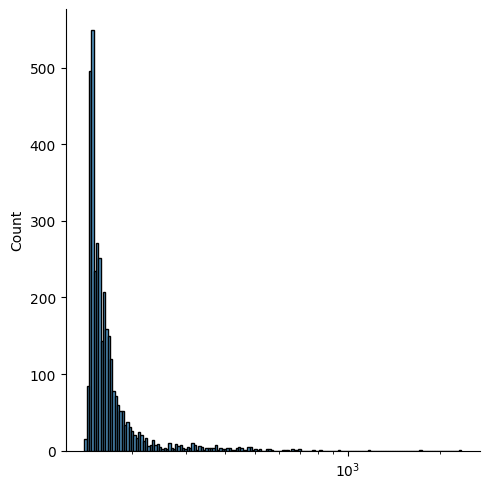

In [25]:
import seaborn as sns

plt.clf()
sns.displot(plate_site_sum.filter((pl.col("plate")=="2025-03-18_B16A1A2_P1T4")&(pl.col("channel")=="GFP"))["perc_50"], log_scale=(True,False))
plt.show()

In [ ]:
plate_well_sum

In [5]:
plate_well_sum.filter((pl.col("channel").str.contains("GFP"))).sort(by=["plate","well"]).join(
    plate_sum, on=["plate","channel"], how="left", suffix="_plate"
).filter(pl.col("well")=="C17") ## pl.col("perc_90")<pl.col("median")

plate,well,channel,perc_25,perc_50,perc_75,perc_80,perc_90,perc_95,perc_99,mean,std,median,mean_plate,std_plate
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64
"""2025-03-17_B16A1A2_P1T1""","""C17""","""GFP""",140.0,158.0,188.0,247.0,589.0,1201.0,8253.0,606.807446,3634.110916,156,469.882565,2663.648157
"""2025-03-18_B16A1A2_P1T2""","""C17""","""GFP""",144.0,162.0,192.0,258.0,669.0,1381.0,10078.0,665.546276,3828.46452,160,518.036096,2846.185983
"""2025-03-18_B16A1A2_P1T3""","""C17""","""GFP""",143.0,163.0,219.0,324.0,873.0,1828.0,15078.0,833.141122,4611.384931,160,526.793039,2894.225504
"""2025-03-18_B16A1A2_P1T4""","""C17""","""GFP""",136.0,153.0,169.0,174.0,272.0,699.0,3785.0,395.946341,2572.120986,0,NaN,NaN


In [ ]:
def summarize_tiff_img(tiff_image_path):
    img = imread(tiff_image_path)
    arr = img.ravel()
    # cast to float64 for safe sum
    s = arr.sum(dtype=np.float64)
    ss = (arr.astype(np.float64) ** 2).sum()
    n = arr.size
    # integer images → bincount histogram
    # minlength covers full dynamic range e.g. 0–65535 for uint16
    hist = np.bincount(arr, minlength=65536)
    return n, s, ss, hist


def summarize_img_parallel(tiff_imgs, output_dict, workers=128):
    """
    Summarize a list of TIFF images in parallel, returning list of (n, s, ss, hist) tuples.
    """
    if type(tiff_imgs)==str:
        tiff_imgs = glob.glob(tiff_imgs, recursive=True)

    if (tiff_imgs):
        results = []
        ## process in parallel with a progress bar
        with ProcessPoolExecutor(max_workers=workers) as exe:
            futures = {exe.submit(summarize_tiff_img, path): path for path in tiff_imgs}
            for fut in tqdm(as_completed(futures), total=len(futures), desc="Summarizing TIFFs"):
                results.append(fut.result())
        
        # reduce
        total_n    = sum(r[0] for r in results)
        total_sum  = sum(r[1] for r in results)
        total_sumsq= sum(r[2] for r in results)
        # element-wise sum of histograms
        total_hist = sum(r[3] for r in results)
        # mean & std
        mean = total_sum / total_n
        std  = np.sqrt(total_sumsq/total_n - mean**2)
        # median: find intensity bin where cumsum ≥ N/2
        cum = np.cumsum(total_hist)
        median = np.searchsorted(cum, total_n//2)
        output_dict.update({"median": median, "mean": mean, "std": std})
        return output_dict
    
    else:
        output_dict.update({"median": np.nan, "mean": np.nan, "std": np.nan})
        return output_dict


def summarize_img_sequential(tiff_imgs, output_dict):
    """
    Summarize a list of TIFF images in parallel, returning list of (n, s, ss, hist) tuples.
    """
    if type(tiff_imgs)==str:
        tiff_imgs = glob.glob(tiff_imgs, recursive=True)

    if (tiff_imgs):
        results = []
        for path in tiff_imgs:
            results.append(summarize_tiff_img(path, output_dict))
        # reduce
        total_n    = sum(r[0] for r in results)
        total_sum  = sum(r[1] for r in results)
        total_sumsq= sum(r[2] for r in results)
        # element-wise sum of histograms
        total_hist = sum(r[3] for r in results)
        # mean & std
        mean = total_sum / total_n
        std  = np.sqrt(total_sumsq/total_n - mean**2)
        # median: find intensity bin where cumsum ≥ N/2
        cum = np.cumsum(total_hist)
        median = np.searchsorted(cum, total_n//2)
        output_dict.update({"median": median, "mean": mean, "std": std})
        return output_dict
    else:
        output_dict.update({"median": np.nan, "mean": np.nan, "std": np.nan})
        return output_dict

In [ ]:
TIFF_IMG_DIR = "../inputs/images"
print("Summarize the per-channel well-level summary statistics:")
output_dir = "../outputs/1.plate_bg_summary/"
batches = ["2025_01_27_Batch_13", "2025_01_28_Batch_14"]

for batch in batches:
    tiff_img_dict_mapper = []
    plates = os.listdir(f"{TIFF_IMG_DIR}/{batch}/images")
    for plate in plates:
        all_tiffs = glob.glob(f"{TIFF_IMG_DIR}/{batch}/images/{plate}/Images/*.tiff")
        unique_wells = sorted(set([tiff.split('/')[-1][:6] for tiff in all_tiffs]))
        print(len(unique_wells)) ## 384
        for well in tqdm(unique_wells):
            well_letter = letter_dict_rev[re.search(r'(?<=r)(\d{2})(?=c)', well)[0]]
            well_num = re.search(r'(?<=c)(\d{2})', well)[0]
            # print(well, result_dict["well"])
            for channel in channel_dict_rev.keys():
                result_dict = {"plate": plate.split("__")[0], 
                               "well": f"{well_letter}{well_num}",
                               "channel": channel_dict_rev[channel]}
                channel_tiffs = f"{TIFF_IMG_DIR}/{batch}/images/{plate}/Images/{well}*-ch{channel}sk*.tiff" # glob.glob(f"{TIFF_IMG_DIR}/{batch}/images/{plate}/Images/{well}*_ch{channel}sk*.tiff", recursive=True)[:100]
                # print(channel_tiffs)
                tiff_img_dict_mapper.append((channel_tiffs, result_dict))

    results_per_well = []
    with ProcessPoolExecutor(max_workers=256) as exe:
        ## submit each (tiff_imgs, output_dict) pair as separate job
        futures = [
            exe.submit(summarize_img_sequential, tiff_imgs, output_dict)
            for tiff_imgs, output_dict in tiff_img_dict_mapper
        ]
        for fut in tqdm(as_completed(futures), total=len(futures), desc="Processing tiffs per well"):
            result = fut.result()
            results_per_well.append(result)

    df = pl.DataFrame(results_per_well)
    df.write_parquet(os.path.join(output_dir, batch, "plate_well_sum_stats.parquet"))

Summarize the per-channel well-level summary statistics:
384


100%|██████████| 384/384 [00:00<00:00, 174327.60it/s]


384


100%|██████████| 384/384 [00:00<00:00, 161805.58it/s]


384


100%|██████████| 384/384 [00:00<00:00, 197912.60it/s]


384


100%|██████████| 384/384 [00:00<00:00, 171105.15it/s]


384


100%|██████████| 384/384 [00:00<00:00, 174082.66it/s]


384


100%|██████████| 384/384 [00:00<00:00, 195178.47it/s]


384


100%|██████████| 384/384 [00:00<00:00, 170525.44it/s]


384


100%|██████████| 384/384 [00:00<00:00, 169022.22it/s]


In [ ]:
# TIFF_IMG_DIR = "../inputs/images"
# print("Summarize the per-channel well-level summary statistics:")
# output_dir = "../outputs/1.plate_bg_summary/"
# batches = ["2025_01_27_Batch_13", "2025_01_28_Batch_14"]

# print("Summarize the per-channel plate-level summary statistics:")
# for batch in batches:
#     tiff_img_dict_mapper = []
#     plates = os.listdir(f"{TIFF_IMG_DIR}/{batch}/images")
#     for plate in tqdm(plates):
#         for channel in channel_dict_rev.keys():
#             channel_tiffs = glob.glob(f"{TIFF_IMG_DIR}/{batch}/images/{plate}/Images/*ch{channel}sk*.tiff", recursive=True)[:100]
#             if channel_tiffs:
#                 result_dict = {"plate": plate.split("__")[0], 
#                                "channel": channel_dict_rev[channel]}
#                 result_dict["channel"] = channel_dict_rev[channel]
#                 tiff_img_dict_mapper.append((channel_tiffs, result_dict))
                
#     results_per_plate = []
#     with ProcessPoolExecutor(max_workers=384) as exe:
#         # submit each (tiff_imgs, output_dict) pair as separate job
#         futures = [
#             exe.submit(summarize_img_parallel, tiff_imgs, output_dict)
#             for tiff_imgs, output_dict in tiff_img_dict_mapper
#         ]
#         for fut in tqdm(as_completed(futures), total=len(futures), desc="Processing tiffs per plate"):
#             result = fut.result()
#             results_per_plate.append(result)
#     df_plate = pl.DataFrame(results_per_plate)
#     df_plate.write_parquet(os.path.join(output_dir, batch, "plate_sum_stats.parquet"))

Summarize the per-channel well-level summary statistics:
Summarize the per-channel plate-level summary statistics:


Summarizing TIFFs: 100%|██████████| 100/100 [00:06<00:00, 14.35it/s]

Summarizing TIFFs: 100%|██████████| 100/100 [00:07<00:00, 14.05it/s]

Processing tiffs per plate: 100%|██████████| 32/32 [01:04<00:00,  2.02s/it]


In [ ]:
## tiff_image
tiff_image_path = "../inputs/images/2025_01_27_Batch_13/images/2025_01_27_B13A7A8P1_T1__2025_01_27T08_46_50_Measurement_1/Images/r01c01f01p01-ch1sk1fk1fl1.tiff"
def process_tiff_img(tiff_image_path):
    img = imread(tiff_image_path)
    print(img.shape)
    # median = float(np.median(img))
    percentiles = np.percentile(img, q=np.array([50,90,95,99]))
    tiff_img_name = tiff_image_path.split("/")[-1]
    site = re.search(r"(?<=f)(\d{2})(?=p)", tiff_img_name.split('-')[0])[0]
    channel = channel_dict_rev[re.search(r"(?<=ch)(\d+)(?=sk)", tiff_img_name.split('-')[1])[0]]
    well_letter = letter_dict_rev[re.search(r'(?<=r)(\d{2})(?=c)', tiff_img_name.split('-')[0])[0]]
    well_num = re.search(r'(?<=c)(\d{2})(?=f)', tiff_img_name.split('-')[0])[0]
    well = f"{well_letter}{well_num}"

    return {"img_path": tiff_image_path, "plate": tiff_image_path.split('/')[-3].split("__")[0], 
            "median": percentiles[0], "perc_90": percentiles[1], "perc_95": percentiles[2], "perc_99": percentiles[3],
            "site": site, "channel": channel, "well": well}

process_tiff_img(tiff_image_path)

# find all TIFFs
# tiff_img_dir = "../inputs/images/"
# paths = glob.glob(f"{tiff_img_dir}/*/images/*/Images/*.tiff", recursive=True)[:100]
# records = []
# # process in parallel with a progress bar
# with ProcessPoolExecutor(max_workers=384) as exe:
#     futures = {exe.submit(process_tiff_img, p): p for p in paths}
#     for fut in tqdm(as_completed(futures), total=len(futures), desc="Processing TIFFs"):
#         rec = fut.result()
#         records.append(rec)

# # build DataFrame and write Parquet
# df = pl.DataFrame(records)

(1080, 1080)


{'img_path': '../inputs/images/2025_01_27_Batch_13/images/2025_01_27_B13A7A8P1_T1__2025_01_27T08_46_50_Measurement_1/Images/r01c01f01p01-ch1sk1fk1fl1.tiff',
 'plate': '2025_01_27_B13A7A8P1_T1',
 'median': 188.0,
 'perc_90': 223.0,
 'perc_95': 235.0,
 'perc_99': 401.0,
 'site': '01',
 'channel': 'DAPI',
 'well': 'A01'}

In [ ]:
img = imread(tiff_image_path)
arr = img.ravel()
# cast to float64 for safe sum
s = arr.sum(dtype=np.float64)
ss = (arr.astype(np.float64) ** 2).sum()
n = arr.size
# integer images → bincount histogram
# minlength covers full dynamic range e.g. 0–65535 for uint16
hist = np.bincount(arr, minlength=65536)